In [53]:
pip install contextily --quiet

Note: you may need to restart the kernel to use updated packages.


In [144]:
pip install piecewise_regression --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import rasterstats
from rasterstats import zonal_stats
import rasterio
import rioxarray as rxr
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as cx
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import piecewise_regression as pwr

In [2]:
spatial_path = "/Users/markos98/aquasteady_research/data/spatial/"
shape_path = "/Users/markos98/aquasteady_research/data/spatial/ca_counties/"
raw_path = "/Users/markos98/aquasteady_research/data/raw/"
transformed_path = "/Users/markos98/aquasteady_research/data/transformed/"

In [49]:
with rasterio.open(spatial_path + "california.tif") as src:
    spi_data = src.read(1)  
    bounds = src.bounds     
    crs = src.crs

In [50]:
counties = gpd.read_file(shape_path + "CA_Counties.shp")
counties = counties.to_crs(crs)  # Match CRS to SPI data

In [51]:
convex_hull = counties[['geometry']].dissolve().convex_hull

In [52]:
convex_hull = gpd.GeoDataFrame(geometry=convex_hull)

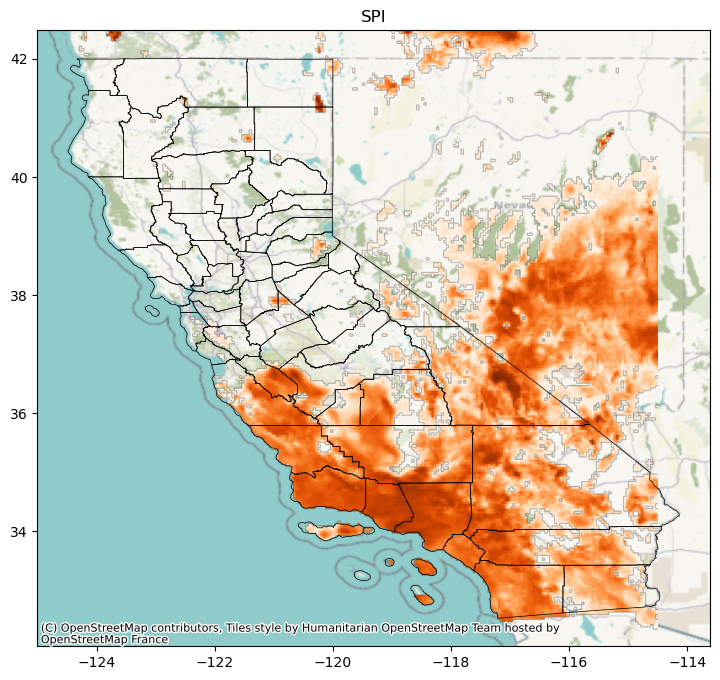

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))

# Overlay watershed boundaries
counties.boundary.plot(ax=ax, linewidth=0.5, color="black")

# convex_hull.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, linestyle='--', label='Convex Hull')

# basemap = cx.providers.Stadia.TerrainBackground

cx.add_basemap(ax, crs = counties.crs.to_string())

show(spi_data, ax=ax, transform=src.transform, cmap="Oranges", alpha=1.0)

# Add USDA irrigation data (if available)
# Example: Color watersheds by irrigation acres
# CA_watersheds.plot(ax=ax, column="Irrigated_Acres", legend=True, alpha=0.3)

plt.title("SPI")
plt.show()

In [55]:
with rasterio.open(spatial_path + "california.tif") as src:
    spi_array = src.read(1)  # NumPy array
    affine_transform = src.transform  # Affine transform

In [56]:
spi_stats = rasterstats.zonal_stats(
    counties, 
    spi_array,
    affine=affine_transform,
    stats=["mean"], 
    geojson_out=True
)

/Volumes/Mac/opt/anaconda3/envs/aquasteady/lib/python3.13/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [57]:
spi = gpd.GeoDataFrame.from_features(spi_stats)

In [14]:
print(spi)

                                             geometry STATEFP COUNTYFP  \
0   POLYGON ((-120.6556 39.69357, -120.65554 39.69...      06      091   
1   POLYGON ((-121.18858 38.71431, -121.18732 38.7...      06      067   
2   MULTIPOLYGON (((-120.7343 34.90069, -120.73431...      06      083   
3   POLYGON ((-120.63095 38.34111, -120.63058 38.3...      06      009   
4   MULTIPOLYGON (((-119.32923 34.22784, -119.3292...      06      111   
5   MULTIPOLYGON (((-118.7034 34.1686, -118.70338 ...      06      037   
6   POLYGON ((-122.93507 38.31396, -122.93511 38.3...      06      097   
7   POLYGON ((-119.95894 36.25547, -119.95894 36.2...      06      031   
8   POLYGON ((-117.43744 33.17953, -117.44955 33.1...      06      073   
9   POLYGON ((-121.06545 39.00654, -121.06538 39.0...      06      061   
10  MULTIPOLYGON (((-122.6123 37.81523, -122.5846 ...      06      075   
11  POLYGON ((-122.7864 37.88695, -122.78705 37.88...      06      041   
12  POLYGON ((-120.32154 37.52441, -12

In [62]:
with open(raw_path + 'ca_insurance.txt', 'r') as f:
    lines = [line.strip().split('|') for line in f if line.strip()]

In [63]:
columns = [
    "Commodity Year",                # 9(04)  
    "Location State Code",           # 9(02)  
    "Location State Abbreviation",   # X(02)  
    "Location County Code",          # 9(03)  
    "Location County Name",          # X(35)  
    "Commodity Code",                # 9(04)  
    "Commodity Name",                # X(30)  
    "Insurance Plan Code",           # 9(02)  
    "Insurance Plan Name Abbreviation",  # X(05)  
    "Coverage Category",             # X(05)  
    "Delivery Type",                 # X(04)  
    "Coverage Level",               # 9(01)/9(04)  
    "Policies Sold Count",           # 9(08)  
    "Policies Earning Premium Count", # 9(08)  
    "Policies Indemnified Count",    # 9(08)  
    "Units Earning Premium Count",   # 9(12)  
    "Units Indemnified Count",       # 9(12)  
    "Quantity Type",                 # X(25)  
    "Net Reported Quantity",         # 9(10)  
    "Endorsed/Companion Acres",      # 9(15)  
    "Liability Amount ($)",          # 9(15)  
    "Total Premium Amount ($)",      # 9(15)  
    "Subsidy Amount ($)",            # 9(15)  
    "State/Private Subsidy ($)",     # 9(15)  
    "Additional Subsidy ($)",        # 9(15)  
    "EFA Premium Discount ($)",      # 9(15)  
    "Indemnity Amount ($)",          # $9(15)  
    "Loss Ratio"                     # 9(04)V9(02)  
]

df = pd.DataFrame(lines, columns=columns)

df = df.dropna(subset=['Location State Code'])

df = df.drop('Commodity Year', axis=1)

In [64]:
df = df[df['Insurance Plan Code'] == '13']

df['Loss Ratio'] = df['Loss Ratio'].astype(float)

df = df.groupby('Location County Name')['Loss Ratio'].mean().reset_index()

In [82]:
counties = pd.read_csv(raw_path + "counties.csv")

In [83]:
counties = counties.merge(
    spi, 
    on="NAME",     
    how="right"     
)

print(f"Merged rows: {len(merged)}") 

Merged rows: 58


In [84]:
counties = counties[["NAME", "Interest expense", "Rent and lease expenses for machinery, equipment, and farm share of vehicles", "Loss Ratio", "mean"]]

In [85]:
counties = counties.rename(columns={'NAME': 'county',
                                    'Interest expense': 'interest', 
                                    'Rent and lease expenses for machinery, equipment, and farm share of vehicles': 'rent',
                                    'Loss Ratio': 'loss',
                                    'mean': 'drought'})

In [88]:
counties.head()

,county,interest,rent,loss,drought
0,Sierra,586,270,1.0575,NaN
1,Sacramento,"20,622","29,615",0.935,NaN
2,Santa Barbara,"37,119","118,597",0.352,1.421696
3,Calaveras,"1,913","3,070",0.936,0.138444
4,Ventura,"30,472","20,602",0.815,1.708708


In [90]:
features = counties[['loss','interest','rent','drought']]

In [95]:
features = features.to_numpy()

In [96]:
from sklearn.preprocessing import StandardScaler
x = counties.loc[:, features].values
x = StandardScaler().fit_transform(x) # normalizing the features

ValueError: Cannot index with multidimensional key

In [72]:
from sklearn.decomposition import PCA
pca_counties = PCA(n_components=2)
principalComponents_counties = pca_counties.fit_transform(x)

NameError: name 'x' is not defined

In [68]:
merged.to_csv('merged.csv', index=True)

In [68]:
formula = "mean ~ total_crop_failure"

In [69]:
model = smf.ols(formula, data=merged).fit()

In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     4.050
Date:                Mon, 12 May 2025   Prob (F-statistic):              0.137
Time:                        11:34:32   Log-Likelihood:                 36.466
No. Observations:                  30   AIC:                            -18.93
Df Residuals:                       3   BIC:                             18.90
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.7584      0.113      6.684      0.007       0.397       1.119
total_crop_failure[T.-]        -0.2811      0.254     -1.108      0.349      -1.088       0.526
total_crop_failure[T.13351]     0.4762      0.254      1.877      0.157      -0.331       1.284
total_crop_failure[T.13554]    -0.2947      0.254     -1.162      0.329      -1.102       0.513
total_crop_failure[T.14574]     0.4762      0.254      1.877      0.157      -0.331       1.284
total_crop_failure[T.16691]    -0.4434      0.254     -1.748      0.179      -1.251       0.364
total_crop_failure[T.1835]      0.6827      0.254      2.691      0.074      -0.125       1.490
total_crop_failure[T.19250]    -0.0061      0.254     -0.024      0.982      -0.813       0.801
total_crop_failure[T.2405]      0.9111      0.254      3.591      0.037       0.104       1.718
total_crop_failure[T.26411]    -0.0061      0.254     -0.024      0.982      -0.813       0.801
total_crop_failure[T.2743]      0.9111      0.254      3.591      0.037       0.104       1.718
total_crop_failure[T.2828]     -0.5976      0.254     -2.356      0.100      -1.405       0.210
total_crop_failure[T.2845]      0.2633      0.254      1.038      0.376      -0.544       1.071
total_crop_failure[T.28973]    -0.4424      0.254     -1.744      0.180      -1.250       0.365
total_crop_failure[T.3079]     -0.5976      0.254     -2.356      0.100      -1.405       0.210
total_crop_failure[T.3424]      0.6827      0.254      2.691      0.074      -0.125       1.490
total_crop_failure[T.41691]     0.0747      0.254      0.294      0.788      -0.733       0.882
total_crop_failure[T.4261]      0.5419      0.254      2.136      0.122      -0.265       1.349
total_crop_failure[T.4759]      0.5419      0.254      2.136      0.122      -0.265       1.349
total_crop_failure[T.5076]     -0.2947      0.254     -1.162      0.329      -1.102       0.513
total_crop_failure[T.5099]      0.2633      0.254      1.038      0.376      -0.544       1.071
total_crop_failure[T.5132]      0.0327      0.254      0.129      0.906      -0.775       0.840
total_crop_failure[T.52461]     0.0747      0.254      0.294      0.788      -0.733       0.882
total_crop_failure[T.61]        0.2747      0.254      1.083      0.358      -0.533       1.082
total_crop_failure[T.65767]    -0.4424      0.254     -1.744      0.180      -1.250       0.365
total_crop_failure[T.732]       0.0327      0.254      0.129      0.906      -0.775       0.840
total_crop_failure[T.8883]     -0.4434      0.254     -1.748      0.179      -1.251       0.364
==============================================================================
Omnibus:                       20.523   Durbin-Watson:                   2.999
Prob(Omnibus):                  0.000   Jarqu

In [54]:
huc2 = gpd.read_file(spatial_path + "huc2-basins.geojson")

In [55]:
print(huc2.head())

   objectid                                   tnmid metasourceid  \
0         1  {9F7DA17F-2AB2-4A27-B6AD-C3475BBA7C4A}         None   
1         2  {7721F096-C381-4519-85C2-2FE21109F869}         None   
2         3  {7271463E-B5E4-4017-8E10-24A186190541}         None   
3         4  {4C2998C0-D39C-47B3-8848-549D9184B95B}         None   
4         5  {5C6AE09C-4CFC-4EBA-9344-A91AF35E73E8}         None   

  sourcedatadesc sourceoriginator sourcefeatureid            loaddate  \
0           None             None            None 2021-06-27 08:35:53   
1           None             None            None 2019-12-05 11:32:03   
2           None             None            None 2016-10-11 16:37:03   
3           None             None            None 2020-02-05 11:05:50   
4           None             None            None 2021-02-01 10:10:42   

  referencegnis_ids     areaacres   areasqkm  \
0              None  1.172622e+08  474543.67   
1              None  3.846772e+06   15567.35   
2       

In [56]:
huc2 = huc2.to_crs(epsg=3857)

In [57]:
huc2 = huc2.drop([1, 17, 2])

In [58]:
random_forest = gpd.read_file(transformed_path + "random_forest.csv")

In [59]:
importances_by_region = huc2.merge(
    random_forest, 
    on="huc2",     
    how="left"     
)

print(f"Merged rows: {len(importances_by_region)}") 

Merged rows: 19


/var/folders/d7/s9v4vr012y797bmw4ryrcfgc0000gn/T/ipykernel_9026/1853512747.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


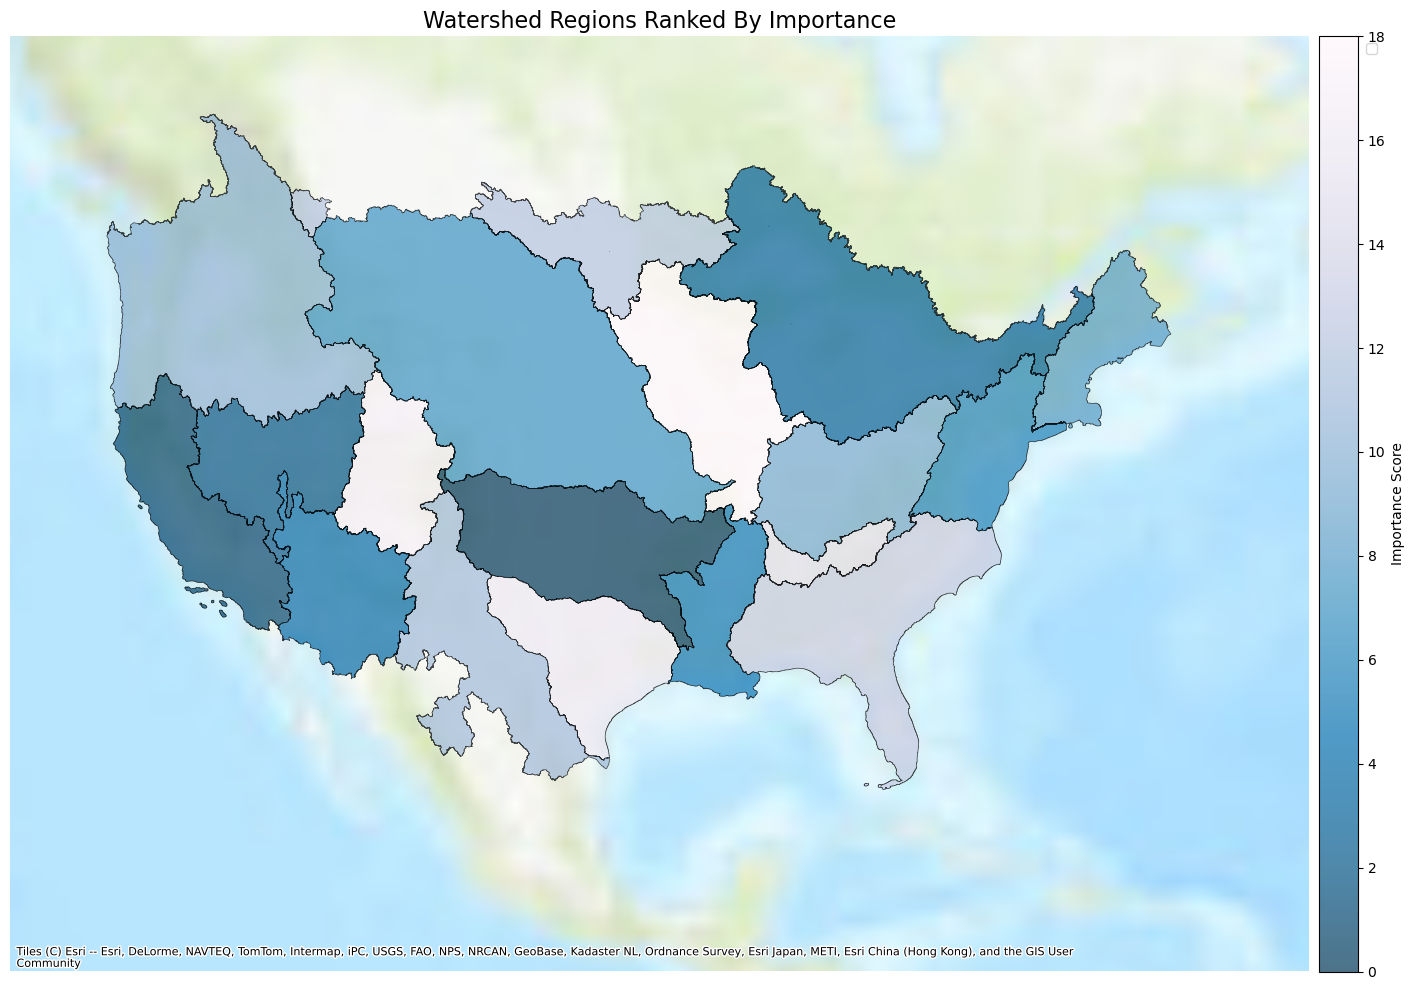

In [93]:
# Create a figure
fig, ax = plt.subplots(figsize=(15, 10))

# Plot watersheds (color by importance or another variable)
importances_by_region.plot(
    ax=ax,
    column="name",  # Replace with your target column (e.g., from random_forest.csv)
    cmap="PuBu_r",
    alpha=0.7,
    edgecolor="k",
    linewidth=0.5,
    legend=False
)

# Label specific regions (adjust names to match your GeoJSON)
regions_to_label = {
    "California": (-1.25e7, 4.0e6),  # Manual position override (optional)
    "Arkansas-White-Red": (-1.0e7, 3.5e6),
    "Missouri": (-1.1e7, 4.8e6)
}

for region_name, (x, y) in regions_to_label.items():
    region = huc2[huc2["name"] == region_name]  # Replace "name" with your GeoJSON's region column
    if not region.empty:
        # Use centroid or manual position
        ax.annotate(
            text=region_name.replace("-", "\n"),  # Split hyphenated names
            xy=(x, y),  # Use manual position or region.geometry.centroid.coords[0]
            ha="center",
            fontsize=10,
            color="black",
            weight="bold",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=2)
        )

# Add subtle colorbar for context (optional)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(ax.collections[0], cax=cax, label="Importance Score")

# Add basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)

# Widen horizontal scope (adjust xlim)
ax.set_xlim(-1.45e7, -6.5e6)  # Wider than before (-1.39e7, -7.35e6)
ax.set_ylim(1.68e6, 7.44e6)   # Keep vertical bounds

# Customize
ax.set_title("Watershed Regions Ranked By Importance", fontsize=16)
ax.set_axis_off()  # Hide axes for a clean map
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.savefig("watershed_map.png", dpi=300)  # Save high-res
plt.show()